# Inference using onnx model

In [244]:
import torch
from mmcv import Config
from mmpose.datasets import build_dataloader, build_dataset
import numpy as np
import onnxruntime
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [245]:
# Create dataset and dataloader using mmpose config


# cfg
cfg = Config.fromfile('../configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py')

cfg.model.pretrained = None
cfg.data.test.test_mode = True

# work_dir
cfg.work_dir = '../work_dirs'
cfg.data.test.ann_file = '../data/freihand/annotations/freihand_test.json'
cfg.data.test.img_prefix = '../data/freihand/'

dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(dataset, samples_per_gpu=1, workers_per_gpu=1, dist=False, shuffle=False)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
=> num_images: 13024
=> load 13024 samples


In [246]:
# Get random img form dataset

i = np.random.randint(0, len(dataset))
x = torch.unsqueeze(dataset[i]['img'], 0)
image_file = dataset[i]['img_metas'].data['image_file']
print(image_file)

../data/freihand/training/rgb/00052131.jpg


In [247]:
# Fix input type
# onnx model input : dict{'input.1': ndarray(1, 3, 224, 224)}
# onnx model output = list[ndarray(1, 21, 56, 56)] -> heatmap

# tensor to numpy
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession("../work_dirs/res50_freihand2d_224x224/tmp3.onnx")

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# print(ort_inputs['input.1'].shape)
# print(ort_outs[0].shape)

In [248]:
# Check onnx model inference speed
# resnet50 : 13it/s



# for k in tqdm(range(len(dataset))):
#     x = torch.unsqueeze(dataset[k]['img'], 0)
#     ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
#     ort_outs = ort_session.run(None, ort_inputs)

In [249]:
# Get keypoint from heatmap using mmpose api mmpose.core.evaluation.keypoints_from_heatmaps

from mmpose.core import evaluation

# c : center, s : scale
# S : [0.896, 0.896] 값이 왜 이렇게 되는 지는 아직 잘 모르겠습니다.
# 다만 mmpose 모델 inference과정에서 값을 확인해봤을 때 c,s값이 일정하게 아래와 같았습니다.

c = np.array([112., 112.], dtype=np.float32)
c = np.expand_dims(c, axis=0)
s = np.array([0.896, 0.896], dtype=np.float32)
s = np.expand_dims(s, axis=0)

result = evaluation.keypoints_from_heatmaps(
        heatmaps=ort_outs[0],
        center=c,
        scale=s
        )
keypoint = result[0][0]
prob = result[1][0]
concat = np.concatenate([keypoint, prob], 1)
print("   x           y              prob\n")
print(concat)

   x           y              prob

[[ 79.2        112.8          0.90205944]
 [ 96.8        103.20001      0.9556354 ]
 [109.600006    92.           0.9902771 ]
 [124.          87.2          0.8965599 ]
 [141.6         79.2          0.90967995]
 [117.600006    93.600006     0.9220717 ]
 [130.4         88.8          0.95937717]
 [143.20001     90.399994     0.9248456 ]
 [160.8         90.399994     0.8934429 ]
 [117.600006   104.8          0.95735186]
 [127.20001    114.399994     0.878678  ]
 [136.8        122.399994     0.68547064]
 [124.         122.399994     0.68016   ]
 [111.20001    119.20001      0.9146636 ]
 [127.20001    122.399994     0.7744522 ]
 [143.20001    124.           0.8002933 ]
 [157.6        127.20001      0.9442983 ]
 [106.399994   130.4          0.9266703 ]
 [114.399994   136.8          0.91811275]
 [122.399994   144.8          0.99234474]
 [128.8        149.6          0.90245575]]


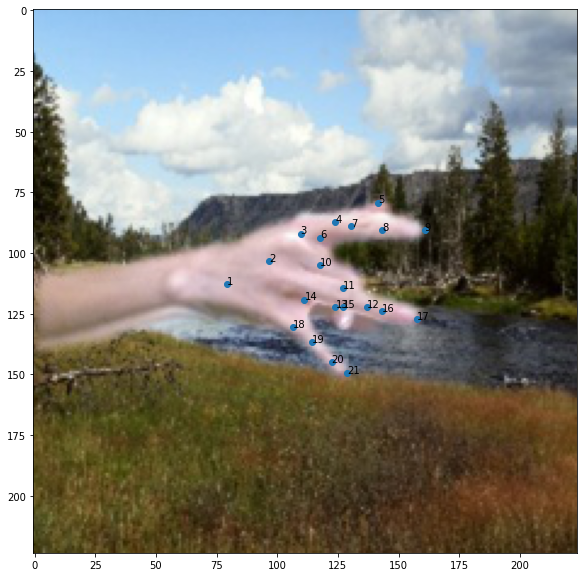

In [250]:
img = mpl.image.imread(image_file)

x = concat[:,0]
y = concat[:,1]
prob = concat[:,2]
n = [i for i in range(1, 22)]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(n[i], (x[i], y[i]))

plt.imshow(img)
plt.show()